### Prove of concept: we should be able to build an almost perfect prime model on modular features 
**modular feature**: is a number dividable by a given prime <br>
target whether int is/ isnt prime is almost a simple linear combination of features

In [1]:
# imports
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd


# sklearn imports
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegressionCV

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay


In [2]:
# params
prime_lim = 500000

#### Build Core Dataset

In [3]:
# read in prime numbers
primes = np.load(f'../../artifacts/primes/prime_{prime_lim}.npy')
primes[:100]

array([  2,   3,   5,   7,  11,  13,  17,  19,  23,  29,  31,  37,  41,
        43,  47,  53,  59,  61,  67,  71,  73,  79,  83,  89,  97, 101,
       103, 107, 109, 113, 127, 131, 137, 139, 149, 151, 157, 163, 167,
       173, 179, 181, 191, 193, 197, 199, 211, 223, 227, 229, 233, 239,
       241, 251, 257, 263, 269, 271, 277, 281, 283, 293, 307, 311, 313,
       317, 331, 337, 347, 349, 353, 359, 367, 373, 379, 383, 389, 397,
       401, 409, 419, 421, 431, 433, 439, 443, 449, 457, 461, 463, 467,
       479, 487, 491, 499, 503, 509, 521, 523, 541], dtype=int64)

In [4]:
# convert to natural numbers with binary target
natural_numbers = np.arange(0,prime_lim)
target = np.zeros(prime_lim, dtype=bool)
target[primes] = True

In [5]:
data = pd.DataFrame(data={'n': natural_numbers[2:], 'y': target[2:]})
data.head()

,n,y
0,2,True
1,3,True
2,4,False
3,5,True
4,6,False


### A: try out small data sets with modular features
--> if we can actually almost garantie a modular signal per prime in training, the models should show almost perfect performance

models: 
- prime cutoff 10000, and the lower 100 primes are used for features --> converges
- prime cutoff 100000, and the lower 100 primes are used for features --> converges
- prime cutoff 500000, and the lower 100 primes are used for features --> converges

In [6]:
model_dict = {
    10000: {},
    100000: {},
    prime_lim: {},
} # prime_cutoff as key for models

n_modular_features = 100 # not all features
target_col = 'y'


for prime_cutoff in model_dict.keys():
    print(prime_cutoff,'\n')
    
    data_a = data[data['n']<prime_cutoff].copy()
    print(data_a.shape)
    
    # create modular features
    features = [data_a['n'].apply(lambda x: 1 if (x%prime==0 and x!=prime) else 0).values for prime in primes[:n_modular_features]]
    features = np.array(features).T
    feature_col = [f"mod_{str(prime)}" for prime in primes[:n_modular_features]]

    data_a = pd.concat([data_a, pd.DataFrame(features, columns=feature_col)], axis=1)

    print(data_a.head())

    # split in train & test    
    X, y = data_a[feature_col], data_a[target_col]
    print(target_col in feature_col)
    
    X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.33, random_state=42)
    
    # train logistic regression as start
    # lbfgs solver, l2 penalty
    clf = LogisticRegressionCV(cv=10, random_state=0, max_iter=500).fit(X_train, y_train)
    
    # store models and data
    model_dict[prime_cutoff]['data'] = data_a.copy()
    model_dict[prime_cutoff]['model'] = clf
    
    model_dict[prime_cutoff]['X_train'] = X_train.copy()
    model_dict[prime_cutoff]['X_test'] = X_test.copy()
    model_dict[prime_cutoff]['y_train'] = y_train.copy()
    model_dict[prime_cutoff]['y_test'] = y_test.copy()

    print('Training completed')


10000 

(9998, 2)
   n      y  mod_2  mod_3  mod_5  mod_7  mod_11  mod_13  mod_17  mod_19  ...  \
0  2   True      0      0      0      0       0       0       0       0  ...   
1  3   True      0      0      0      0       0       0       0       0  ...   
2  4  False      1      0      0      0       0       0       0       0  ...   
3  5   True      0      0      0      0       0       0       0       0  ...   
4  6  False      1      1      0      0       0       0       0       0  ...   

   mod_467  mod_479  mod_487  mod_491  mod_499  mod_503  mod_509  mod_521  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   mod_523  mod_541  
0        0      

In [7]:
# create predictions for evaluation of models

for prime_cutoff in model_dict.keys():
    curmod = model_dict[prime_cutoff]
    curmod['y_pred'] = curmod['model'].predict(curmod['X_test'])


#### Check overall performance of models

In [8]:
for prime_cutoff in model_dict.keys():
    print(f'model with prime cutoff {prime_cutoff}')
    curmod = model_dict[prime_cutoff]
    print('confusion matrix \n', confusion_matrix(curmod['y_test'], curmod['y_pred']), '\n')

    print(classification_report(curmod['y_test'], curmod['y_pred']))


model with prime cutoff 10000
confusion matrix 
 [[2905    0]
 [   0  395]] 

              precision    recall  f1-score   support

       False       1.00      1.00      1.00      2905
        True       1.00      1.00      1.00       395

    accuracy                           1.00      3300
   macro avg       1.00      1.00      1.00      3300
weighted avg       1.00      1.00      1.00      3300

model with prime cutoff 100000
confusion matrix 
 [[29836     7]
 [    0  3157]] 

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     29843
        True       1.00      1.00      1.00      3157

    accuracy                           1.00     33000
   macro avg       1.00      1.00      1.00     33000
weighted avg       1.00      1.00      1.00     33000

model with prime cutoff 500000
confusion matrix 
 [[150960    248]
 [     0  13792]] 

              precision    recall  f1-score   support

       False       1.00      1.00      1.00

very few misclassification in every model

#### Confusion matrix depending on signal in modular features for models
**When do we have misclassifications?** <br>
-> all false positives (not prime, but predicted as prime) should have no signal in modular features (like no single modular feature = 1) <br>
-> all false negatives (prime, but not predicted as prime) cannot have any modular signal (as they are not prime) -> so how does this misclassification happen? <br>

<br> 
- ideally, the model would perfectly learn that no modular signal = prime -> that would eliminate all false negatives <br>
- introducing other features than just modular features would help to reduce the false positives

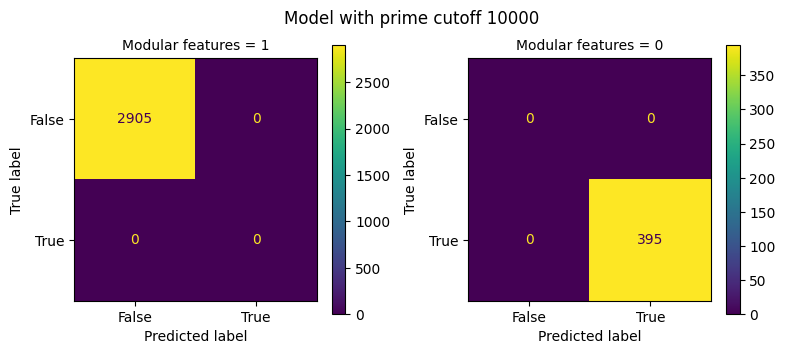

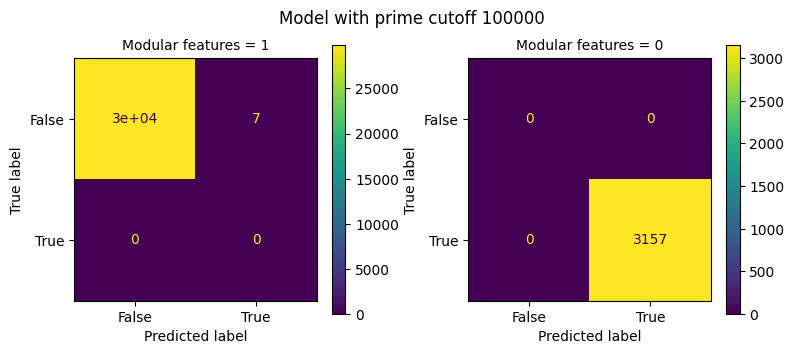

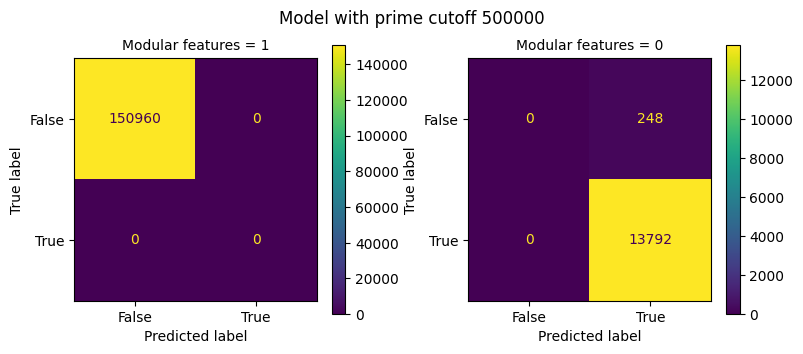

In [9]:
for i, prime_cutoff in enumerate(model_dict.keys()):
    fig, ax = plt.subplots(1,2, figsize=(9, 3.5))

    curmod = model_dict[prime_cutoff]

    mod_features = curmod['model'].feature_names_in_

    # add new superposition of modular features to dataframe
    curmod['X_test']['any_mod'] = curmod['X_test'][mod_features].aggregate('sum',axis=1)>0

    # confusion matrix with any modular features
    cm_mod = confusion_matrix(curmod['y_test'][curmod['X_test']['any_mod']], curmod['y_pred'][curmod['X_test']['any_mod']], labels=curmod['model'].classes_)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm_mod,
                              display_labels=curmod['model'].classes_)

    disp.plot(ax=ax[0])
    
    # confusion matrix without any modular features
    cm_nonmod = confusion_matrix(curmod['y_test'][curmod['X_test']['any_mod']==False], curmod['y_pred'][curmod['X_test']['any_mod']==False], labels=curmod['model'].classes_)


    disp = ConfusionMatrixDisplay(confusion_matrix=cm_nonmod,
                                  display_labels=curmod['model'].classes_)
    disp.plot(ax=ax[1])

    ax[0].set_title('Modular features = 1', size=10)
    ax[1].set_title('Modular features = 0', size=10)

    plt.suptitle(f"Model with prime cutoff {prime_cutoff}")
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.show()


- first model has perfect classification
- second model classifies some primes with instead of modular features, but no modular feature = prime (and is true in test set)
- third model correctly classifies any number with any modular signal as "not prime" but misclassifies all which are prime although there is no modular signal
  --> we now have to find other features which might help with this false positive group

### B: lets try to move away from modular features
- modular features are trivial, because if we provide them all, the recognition of "prime / no prime" is a simple linear superposition <br>
- lets try to find other features and reduce modular features

models:
- prime cutoff 500000, and the lower 50 primes are used for features, no other features -> converges
- prime cutoff 500000, and the lower 50 primes are used for features, some other normalized features added
  -> converges
  -> do the new features help AT ALL in reducing false positives?


In [43]:
n_modular_features = 50 # not all features
target_col = 'y'

data_b = data[data['n']<prime_cutoff].copy()

In [44]:
# create modular features
features = [data_b['n'].apply(lambda x: 1 if (x%prime==0 and x!=prime) else 0).values for prime in primes[:n_modular_features]]
features = np.array(features).T
feature_col = [f"mod_{str(prime)}" for prime in primes[:n_modular_features]]

data_b = pd.concat([data_b, pd.DataFrame(features, columns=feature_col)], axis=1)

# print(data_b.head())

In [45]:
# non-modular features

data_b['n+1'] = data_b['n'].apply(lambda x: x+1)
data_b['n-1'] = data_b['n'].apply(lambda x: x-1)
data_b['2n'] = data_b['n'].apply(lambda x: x*2)
data_b['n**2'] = data_b['n'].apply(lambda x: x**2)
data_b['n%2'] = data_b['n'].apply(lambda x: x%2) # this might be too strong as an indicator?

# distance to last prime?
# number of primes before this number
# dividing current number by last prime? 
# what is last prime?

data_b['last_prime']=data_b['n'].apply(lambda x: primes[primes<x].max() if x!=2 else -1)
data_b['primes_lower_n']=data_b['n'].apply(lambda x: len(primes[primes<x]) if x!=2 else 0)
data_b['n_div_last_prime']=data_b.apply(lambda x: x['n']/x['last_prime'] if x['n']!=2 else -1, axis=1)
data_b['n_minus_last_prime']=data_b.apply(lambda x: x['n']-x['last_prime'] if x['n']!=2 else -1, axis=1)


In [46]:
feature_col = data_b.columns.drop(target_col)
print(target_col in feature_col)


False


In [47]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_b[feature_col] = scaler.fit_transform(data_b[feature_col])

In [48]:
# split in train & test    
X, y = data_b[feature_col], data_b[target_col]

X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.33, random_state=42)

# train logistic regression as start
# lbfgs solver, l2 penalty
clf = LogisticRegressionCV(cv=10, random_state=0, max_iter=500).fit(X_train, y_train)

In [49]:
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
cm

array([[148512,   2696],
       [     0,  13792]], dtype=int64)

In [51]:
# coefs != feature importance...
cm.coef_

array([[-0.28066568, -3.56162422, -5.80593982, -5.21774382, -4.88756916,
        -4.4815954 , -4.34077529, -4.14463436, -4.06040192, -3.9181935 ,
        -3.74830853, -3.71011689, -3.56425245, -3.50592246, -3.46789805,
        -3.3470226 , -3.34347626, -3.20811404, -3.19427755, -3.12820308,
        -3.0835448 , -3.01501356, -2.97681634, -2.90046597, -2.87569431,
        -2.79390597, -2.70692557, -2.74032276, -2.7070645 , -2.64657261,
        -2.62555797, -2.44066696, -2.53343347, -2.45638622, -2.49403467,
        -2.36568073, -2.36682617, -2.30815579, -2.31099118, -2.2744671 ,
        -2.26975279, -2.11554809, -2.18639138, -2.05508012, -2.07956338,
        -2.0722903 , -2.0607859 , -2.04035239, -1.88743032, -1.90061556,
        -1.93411827, -0.28066568, -0.28066568, -0.28066568,  0.99645581,
         3.65878649, -0.28070913, -0.46745025,  0.08761613,  0.15083589]])